### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.


In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import os
import torch     
from torch import nn                                
from IPython import display

**GETTING THE DATASET:**
- I have used google colab for this project so the process of downloading and reading the data might be different in other platforms. I will use [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/) for this project. The dataset is divided into training and testing and each contains 25000 movie reviews. 

In [5]:
#@ GETTING THE DATASET: 
batch_size = 64                                                     # Initializing Batch Size. 
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)       # Initializing Training and Test Iterations. 

### **TEXT CONVOLUTIONAL NEURAL NETWORKS:**
- Text CNN uses a one dimensional convolutional layer and max over time pooling layer. I will use two embedding layers: one with fixed weight and another that participates in training. 

In [6]:
#@ IMPLEMENTATION OF TEXT CONVOLUTIONAL NEURAL NETWORKS: 
class TextCNN(nn.Module):                                                     # Initializing Text CNN. 
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, 
               **kwargs):                                                     # Initializing Constructor Function. 
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)                     # Initializing Embedding Layer. 
    self.constant_embedding = nn.Embedding(vocab_size, embed_size)            # Initializing Constant Embedding Layer. 
    self.dropout = nn.Dropout(0.5)                                            # Initializing Dropout Layer. 
    self.decoder = nn.Linear(sum(num_channels), 2)                            # Initializing Linear Layer. 
    self.pool = nn.AdaptiveAvgPool1d(1)                                       # Initializing Pooling Layer. 
    self.relu = nn.ReLU()                                                     # Initializing RELU Activation Function. 
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))                      # Initializing Convolutional Layer. 
  
  def forward(self, inputs):
    embeddings = torch.cat((self.embedding(inputs), 
                            self.constant_embedding(inputs)), dim=2)          # Concatenating output of Embedding Layers. 
    embeddings = embeddings.permute(0, 2, 1)                                  # Changing Dimensions. 
    encoding = torch.cat([torch.squeeze(
        self.relu(self.pool(conv(embeddings))), dim=-1) for 
        conv in self.convs], dim=1)                                           
    outputs = self.decoder(self.dropout(encoding))                            # Implementation of Linear Layer. 
    return outputs

In [7]:
#@ INITIALIZING TEXT CONVOLUTIONAL NEURAL NETWORKS: 
embed_size, kernel_sizes, num_channels = 100, [3, 4, 5], [100, 100, 100]      # Initializing Parameters. 
devices = d2l.try_all_gpus()                                                  # Initialization. 
net = TextCNN(len(vocab), embed_size, kernel_sizes, num_channels)             # Initializing Text CNN. 
#@ INITIALIZING WEIGHTS: 
def init_weights(m):                                                          # Function for Initializing Weights. 
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight)                                         # Xavier Initialization. 
net.apply(init_weights);

**PRETRAINED WORD VECTORS:**
- Inorder to prevent overfitting, I will directly use word vectors pretrained on a larger corpus as the feature vectors of all words. 

In [9]:
#@ LOADING PRETRAINED WORD VECTORS: 
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")              # Initializing 100D Glove Word Vector. 
embeds = glove_embedding[vocab.idx_to_token]                       # Word Vectors in Vocabulary. 
net.embedding.weight.data.copy_(embeds)                            # Using Word Vectors as Features. 
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False                         

**TRAINING AND EVALUATING MODEL:**

loss 0.067, train acc 0.976, test acc 0.871
3272.1 examples/sec on [device(type='cuda', index=0)]


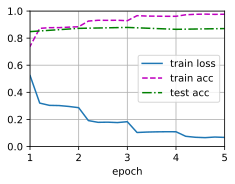

In [10]:
#@ TRAINING THE MODEL: 
lr, num_epochs = 0.001, 5                                          # Initializing Parameters. 
trainer = torch.optim.Adam(net.parameters(), lr=lr)                # Initializing Adam Optimizer. 
loss = nn.CrossEntropyLoss(reduction="none")                       # Initializing Cross Entropy Loss Function. 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 
               num_epochs, devices)                                # Training the Model. 

In [16]:
#@ MODEL EVALUATION:
def predict_sentiment(net, vocab, sentence):                                # Defining Prediction Function. 
  sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
  label = torch.argmax(net(sentence.reshape(1, -1)), axis=1)
  return "positive" if label == 1 else "negative"
#@ IMPLEMENTATION: 
predict_sentiment(net, vocab, "I hate the movie because of story")          # Model Evaluation. 

'negative'